# Support Vector Machine Test for IFFT Slope Model

## Building training data

Import libraries.

In [52]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

Fetch historical stock data for a given ticker using yfinance.

In [31]:
ticker = "AAPL"  # You can replace this with any stock symbol, e.g., 'GOOGL', 'MSFT', etc.
start_date = "2022-01-01"
end_date = "2024-08-01"

# Download the data
df = yf.download(ticker, start=start_date, end=end_date)

df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'],axis = 1,inplace = True)
df.reset_index(inplace=True, drop=True)

[*********************100%***********************]  1 of 1 completed


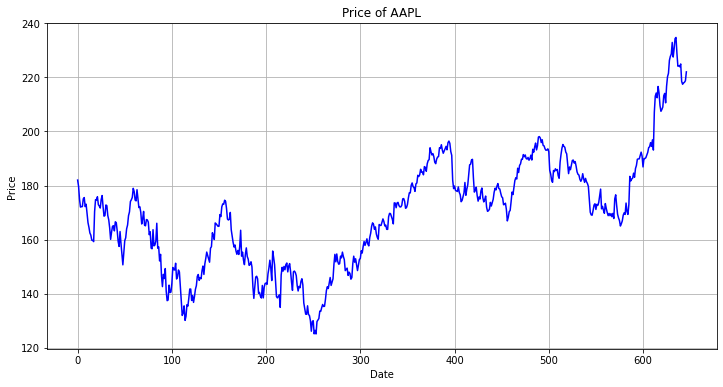

In [32]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Price', color='blue')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Price of {ticker}')
plt.grid()
plt.show()

### Adjustable technical parameters

volatility_window = Time period of variance calculation.

window_size = Length of rolling window. Length is defined as number of indicies.

slope_length = IFFT slope length is calculated over n number of ticks.

target_price = The target price as a %.

stop_loss = The stop loss as a %.

In [33]:
# Volatility window size
volatility_window = 30

# IFFT Window size
n = len(df)
window_size = min(20, n)

# IFFT Slope Long length
slope_length = 30 

# Target price
target_price = 0.04

# Stop loss
stop_loss = 0.02

### Calculate Volatility

Volatility is a measure of that variance bounded by a specific time period.

In [34]:
# Defining column
df['Volatility'] = 0

# Calculating variance over n ticks
for i in range(len(df)):
    if i > volatility_window:
        df['Volatility'].iloc[i] = np.var(df['Close'].iloc[i-volatility_window:i])

Plot Results.

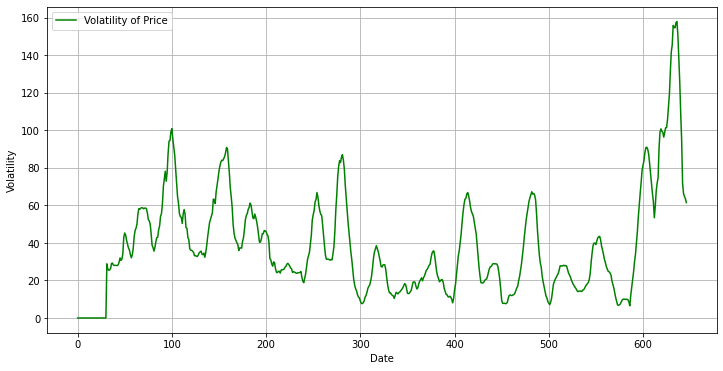

In [35]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Volatility'], label='Volatility of Price', color='green')

plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.legend()
plt.show()

### Inverse Fast Fourier Transform

Function to calculate IFFT for whole dataset.

In [36]:
 # Calculate IFFT
    
# IFFT Indicator with Padding
def ifft_indicator(prices, threshold, padding):
    n = len(prices)
    
    # Pad the prices with reflection at both ends
    padding_size = int(n * padding)  # 0.5 = 50% of the size for padding
    padded_prices = np.pad(prices, (padding_size, padding_size), mode='reflect')

    fft_transformed = np.fft.fft(padded_prices)
    fft_filtered = np.zeros_like(fft_transformed)

    retain_length = int(threshold * len(padded_prices))
    fft_filtered[:retain_length] = fft_transformed[:retain_length]
    fft_filtered[-retain_length:] = fft_transformed[-retain_length:]

    ifft_transformed = np.fft.ifft(fft_filtered).real

    # Remove padding
    ifft_transformed = ifft_transformed[padding_size:-padding_size]

    return ifft_transformed  

Calculate rolling window for IFFT.

In [37]:
# Rolling window
df['IFFT Rolling Window'] = np.nan
for i in range(len(df) - window_size):
    window_data = df.loc[i: i+window_size]
    window_closing_prices = window_data['Close'].values
    window_ifft_result = ifft_indicator(window_closing_prices, threshold=0.05, padding=0.5) #0.05, 0.5
    df['IFFT Rolling Window'].iloc[i+window_size] = window_ifft_result[-1]

Plot results.

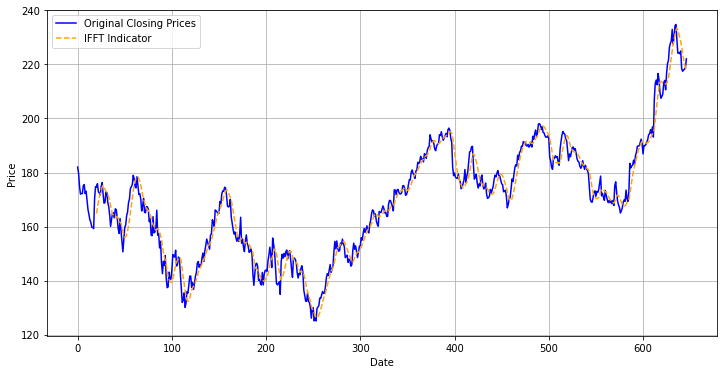

In [38]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original Closing Prices', color='blue')
plt.plot(df.index, df['IFFT Rolling Window'], label='IFFT Indicator', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend()
plt.show()

### Calculate short and long term IFFT slope

Short term slope informs the model of the immediate direction and short term trend of the price. Information that would be otherwise unavailable if only looking at the current price.

The long term slope is calculated to inform the model of the long/medium term trend of the stock

This also allows the model to recieve time series data from past stock ticks, rather than soley relying on one dimensional data from the current point in time. For example, if the slope length is set to 30, the model is able to see data from the previous 30 ticks.

An alternative to this method might be creating new columns with data for current price - n, which would be far less efficient.

In [39]:
# Calculate the slope of the IFFT
df['IFFT Slope Short'] = 0
df['IFFT Slope Short'] = df['IFFT Rolling Window'].diff()

# Calculate long IFFT Slope
df['IFFT Slope Long'] = 0
for i in range(len(df)):
    if i > slope_length:
        df['IFFT Slope Long'].iloc[i] = (df['IFFT Rolling Window'].iloc[i] - df['IFFT Rolling Window'].iloc[i-slope_length]) / (slope_length - 1)

# Fix dataframe
df.reset_index(inplace=True, drop=True)
df = df[df['IFFT Slope Long'] != 0]
df = df[df['Volatility'] != 0]
df = df.dropna()

Plot slope data.

Include hypothetical threshold where slope above that threshold could trigger a buy or sell signal.

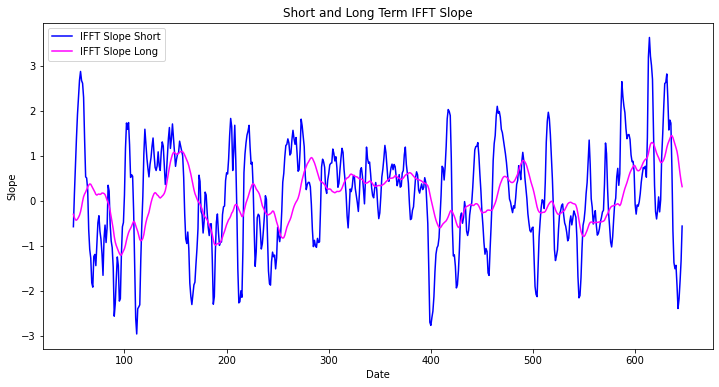

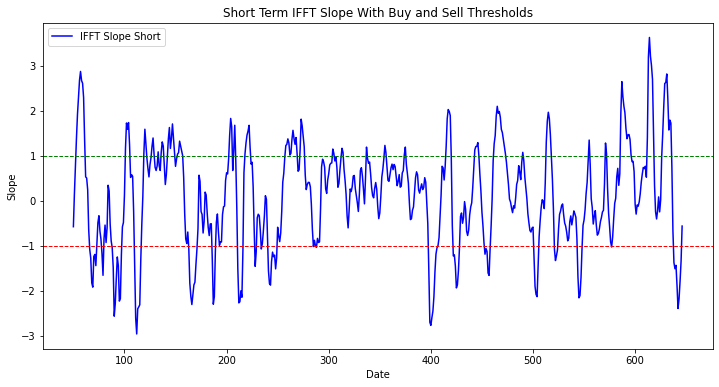

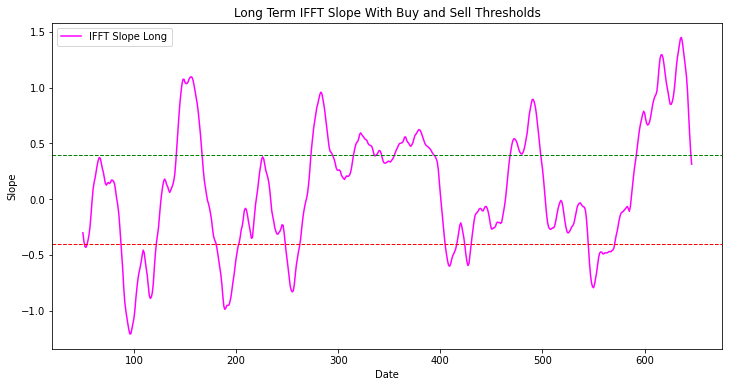

In [40]:
# Plotting short and long term IFFT slope
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IFFT Slope Short'], label='IFFT Slope Short', color='blue')
plt.plot(df.index, df['IFFT Slope Long'], label='IFFT Slope Long', color='magenta')

# Labeling graph
plt.title('Short and Long Term IFFT Slope')
plt.xlabel('Date')
plt.ylabel('Slope')
plt.legend()
plt.show()

# Plotting short term IFFT slope
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IFFT Slope Short'], label='IFFT Slope Short', color='blue')

# Add theoretical short slope threshold
plt.axhline(y=1, color='green', linestyle='--', linewidth=1)

# Add theoretical short slope threshold
plt.axhline(y=-1, color='red', linestyle='--', linewidth=1)

# Labeling graph
plt.title('Short Term IFFT Slope With Buy and Sell Thresholds')
plt.xlabel('Date')
plt.ylabel('Slope')
plt.legend()
plt.show()

# Plotting long term IFFT slope
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['IFFT Slope Long'], label='IFFT Slope Long', color='magenta')

# Add theoretical long slope threshold
plt.axhline(y=0.4, color='green', linestyle='--', linewidth=1)

# Add theoretical long slope threshold
plt.axhline(y=-0.4, color='red', linestyle='--', linewidth=1)

# Labeling graph
plt.title('Long Term IFFT Slope With Buy and Sell Thresholds')
plt.xlabel('Date')
plt.ylabel('Slope')
plt.legend()
plt.show()

### Labeling data



In [41]:
# Add direction column to label data
df['Direction'] = 0 # 1 for up, -1 for down

# Loop over data to determine the movement
for i in range(len(df)):
    current_price = df['Close'].iloc[i]
    found_movement = False  # Flag to indicate if a movement was found

    # Check for price movement within the subsequent days
    for j in range(i + 1, len(df)):
        future_price = df['Close'].iloc[j]
        change = (future_price - current_price) / current_price

        if change >= target_price:
            df['Direction'].iloc[i] = 1  # Upward Win
            found_movement = True
            break  # Stop after the first movement is found

        elif change <= stop_loss * -1:
            break  # Stop after the first movement is found

    # Check for price movement within the subsequent days
    for j in range(i + 1, len(df)):
        future_price = df['Close'].iloc[j]
        change = (future_price - current_price) / current_price

        if change <= target_price * -1:
            df['Direction'].iloc[i] = -1  # Upward Win
            found_movement = True
            break  # Stop after the first movement is found

        elif change >= stop_loss:
            break  # Stop after the first movement is found

    # If no movement found within the loop, record as loss
    if not found_movement:
        df['Direction'].iloc[i] = 0  # No movement

Plot data.

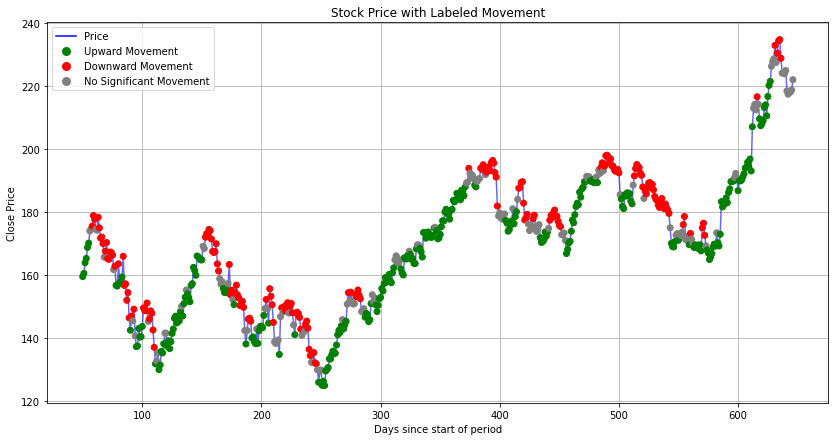

In [42]:
# Plot the stock prices
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', color='blue', alpha=0.6)

# Create a list with colors based on the values in the 'Direction' column
colors = ['red' if x == -1 else 'grey' if x == 0 else 'green' for x in df['Direction']]

# Plot prices with color-coded results
plt.scatter(df.index, df['Close'], c=colors, label='Ticks', zorder=5)

# Customize the plot
plt.title('Stock Price with Labeled Movement')
plt.xlabel('Days since start of period')
plt.ylabel('Close Price')

# Add a legend to explain the color coding
legend_labels = {
    'blue': 'Price',
    'green': 'Upward Movement',
    'red': 'Downward Movement',
    'grey': 'No Significant Movement'
}

# Create custom legend handles
legend_handles = [plt.Line2D([0], [0], linestyle='-', color='blue', label=legend_labels['blue']),
    plt.Line2D([0], [0], marker='o', color='w', label=legend_labels['green'],
               markersize=10, markerfacecolor='green'),
    plt.Line2D([0], [0], marker='o', color='w', label=legend_labels['red'],
               markersize=10, markerfacecolor='red'),
    plt.Line2D([0], [0], marker='o', color='w', label=legend_labels['grey'],
               markersize=10, markerfacecolor='grey')]

# Add legend to plot
plt.legend(handles=legend_handles, loc='upper left')

plt.grid(True)
plt.show()

In [43]:
# Removing no movement value because it is not relevant to prediction, increases autocorrelation
df = df[df['Direction'] != 0]
df.reset_index(inplace=True, drop=True)
df.head()

,Close,Volatility,IFFT Rolling Window,IFFT Slope Short,IFFT Slope Long,Direction
0,159.589996,45.300730,156.037550,-0.577492,-0.301923,1
1,160.619995,44.101468,156.189847,0.152296,-0.378147,1
2,163.979996,41.228274,156.961803,0.771956,-0.424839,1
3,165.380005,39.180245,158.346443,1.384640,-0.432775,1
4,168.820007,37.238709,160.262172,1.915730,-0.409298,1


### Testing for Autocorrelation

Importing Statistics Libraries

In [44]:
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using the Durbin-Watson Test to check for autocorrelation

In [45]:
# Split the data
X = df.drop(columns=['Direction'])

y = df['Direction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a logistic regression model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Get predictions
y_pred_durbin = model.predict(X_test)

# Compute residuals
residuals = y_test - y_pred_durbin

# Durbin-Watson Test
dw_stat = durbin_watson(residuals)

print(f'Durbin-Watson Statistic: {dw_stat:.4f}')

Durbin-Watson Statistic: 1.9118


### Testing for multicollinearity

Correlation Matrix

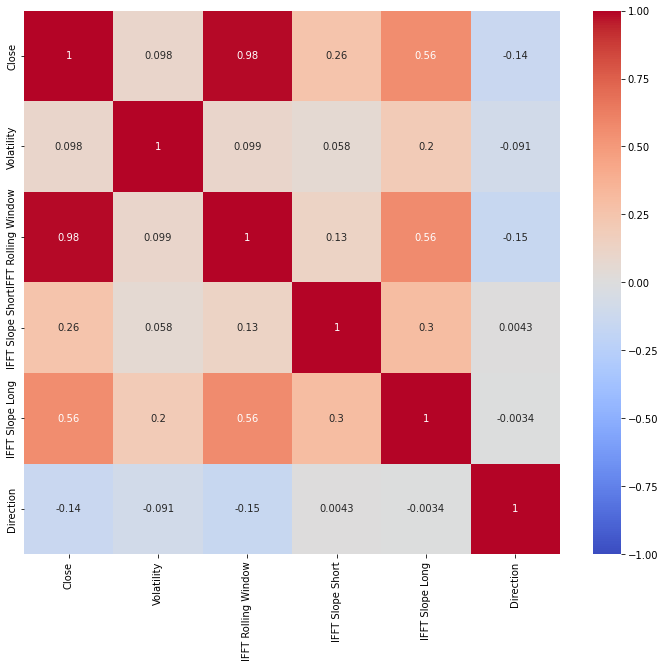

In [46]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

Variance Inflation Factor

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant to the features matrix (intercept term)
df_copy = df.copy()
df_copy['intercept'] = 1

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = df_copy.columns
vif_data['VIF'] = [variance_inflation_factor(df_copy.values, i) for i in range(df_copy.shape[1])]

print(vif_data)

               feature         VIF
0                Close   82.144917
1           Volatility    1.052280
2  IFFT Rolling Window   81.742662
3     IFFT Slope Short    2.735209
4      IFFT Slope Long    1.766207
5            Direction    1.044542
6            intercept  105.825466


Correlation Matrix and Variance Inflation Factor suggest high multicolinearity. The most significant contributor being the Close Price and IFFT Rolling Window. Eliminate the close price.

In [48]:
# Dropping close price because of heavy milticolinearity
X.drop(['Close'],axis = 1,inplace = True)

# Select y varaible
y = df['Direction']

## Support Vector Machine

Using K-Fold Cross Validation to address overfitting.

In [82]:
 # Train the model with a non-linear kernel
model = SVC(kernel='rbf', C=1000, gamma = 0.1, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
# Manual K-fold cross-validation
accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)
    y_pred_test = model.predict(X_test_scaled)
            
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies.append(round(accuracy, 2))

print(f"Cross-validation accuracies: {accuracies}")

Cross-validation accuracies: [0.87, 0.86, 0.85, 0.9, 0.81]


### Model Evaluation

Check for overfitting

In [72]:
y_pred_train = model.predict(X_train_scaled)

accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {accuracy:.2f}")

# Make predictions with the best model
y_pred_test = model.predict(X_test_scaled)

# Checking accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Average cross-validation accuracy: {sum(accuracies)/len(accuracies):.2f}")

Training Accuracy: 0.95
Average cross-validation accuracy: 0.86


Confusion Matrix

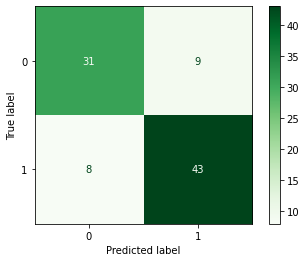

In [73]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test, labels=np.unique(y))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')

# Show the plot
plt.show()

### Vizualizing data

Using PCA to data so it can be graphed in 2-3 dimensions.

In [74]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

pca_values = pd.DataFrame({'expl_var': pca.explained_variance_ratio_, 
                      'component': range(1,5), 
                      'cum_variance': pca.explained_variance_ratio_.cumsum()})

pca_values

,expl_var,component,cum_variance
0,0.637591,1,0.637591
1,0.361315,2,0.998906
2,0.000942,3,0.999848
3,0.000152,4,1.000000


In [78]:
df_pca = pca.transform(X)
df_pca = pd.DataFrame(df_pca[:, 1:4])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_pca['Predicted Direction'] = model.predict(X_scaled)
df_pca

,0,1,2,Predicted Direction
0,13.357971,0.706668,-0.124376,-1
1,12.995068,-0.007013,-0.299295,-1
2,11.729595,-0.614284,-0.433582,1
3,10.004787,-1.213190,-0.538873,1
4,7.775809,-1.731046,-0.609158,1
...,...,...,...,...
454,-37.428564,-2.078338,-0.313717,-1
455,-39.586245,-0.810939,-0.078973,1
456,-41.392631,-1.023828,-0.070528,-1
457,-42.611617,-0.945561,-0.038030,-1


3D Scatter Plot

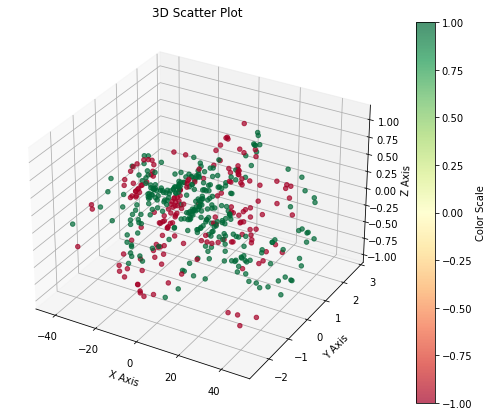

In [80]:
# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca[0], df_pca[1], df_pca[2], c=df_pca['Predicted Direction'], cmap='RdYlGn', alpha=0.7)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Color Scale')

# Labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Scatter Plot')

# Show plot
plt.show()